In [1]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [3]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

# train_fft = normalize_fft(train_fft)
# test_fft = normalize_fft(test_fft)

1.0 0.0 (299.0078472062014+0j) (-105.1554452474781-85.19899857776973j)


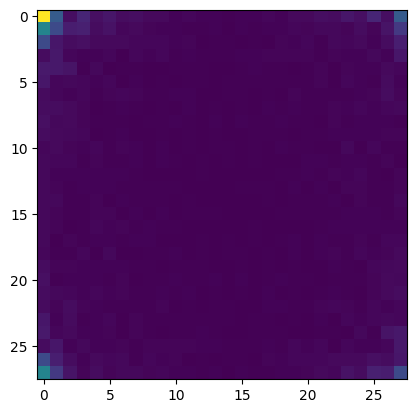

In [4]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [5]:
def phase_shift_fourier(fourier_image, x=2.0, y=2.0):
    """
    Perform a random phase shift on a Fourier-image, constrained by maximum values.
    
    Parameters:
    fourier_image (torch.tensor): Complex-valued centered Fourier representation of an image
    x (float): Maximum amount to shift in x direction (0-2 range recommended due to 2pi periodicity)
    y (float): Maximum amount to shift in y direction (0-2 range recommended due to 2pi periodicity)
    
    Returns:
    torch.tensor: The phase-shifted Fourier-image
    """
    fourier_image = torch.fft.fftshift(fourier_image)
    rows, cols = fourier_image.shape
    
    # Generate random shift amounts within the specified ranges
    random_x = torch.rand(1).item() * x
    random_y = torch.rand(1).item() * y
    shift_x = random_y * torch.pi * rows
    shift_y = random_x * torch.pi * cols
    
    freq_x = torch.fft.fftfreq(cols)
    freq_y = torch.fft.fftfreq(rows)
    fx, fy = torch.meshgrid(freq_x, freq_y, indexing='ij')
    
    # Calculate and apply phase shift
    phase_shift = torch.exp(-1j * (shift_x * fx + shift_y * fy))
    shifted_fourier_image = torch.fft.fftshift(fourier_image * phase_shift)
    
    return shifted_fourier_image


def mask_frequency_spectrum(spectrum, max_mask_percentage):
    # Ensure the max_mask_percentage is between 0 and 100
    max_mask_percentage = torch.clamp(torch.tensor(max_mask_percentage), 0, 100)
    
    # Generate a random mask percentage
    mask_percentage = torch.rand(1) * max_mask_percentage
    
    # Calculate the number of elements to mask
    num_elements = spectrum.numel()
    num_masked = int(num_elements * mask_percentage.item() / 100)
    
    # Create a flat copy of the spectrum
    flat_spectrum = spectrum.view(-1)
    
    # Randomly select indices to mask
    mask_indices = torch.randperm(num_elements)[:num_masked]
    
    # Create a mask tensor
    mask = torch.ones_like(flat_spectrum, dtype=torch.bool)
    mask[mask_indices] = False
    
    # Apply the mask
    masked_spectrum = flat_spectrum.clone()
    masked_spectrum[~mask] = 0
    
    # Reshape the spectrum back to its original shape
    masked_spectrum = masked_spectrum.view(spectrum.shape)
    
    return masked_spectrum

In [44]:
class CustomTransform:
    def __init__(self, is_training=True):
        self.is_training = is_training
        
    def __call__(self, sample):
        img, fft = torch.tensor(np.array(sample))
        if self.is_training: 
            fft = torch.fft.fftshift(fft)
            #fft = phase_shift_fourier(fft)
            fft = mask_frequency_spectrum(fft, 75)
            fft = torch.fft.fftshift(fft)
        # Split the complex FFT into real and imaginary parts
        fft_real = torch.real(fft)
        fft_imag = torch.imag(fft)
        fft_stacked = torch.stack([fft_real, fft_imag])

        
        return fft_stacked.float()

In [45]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels, is_training=True):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform(is_training)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [46]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, is_training=True)

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [47]:
item = next(iter(train_loader))

torch.Size([64, 2, 28, 28])


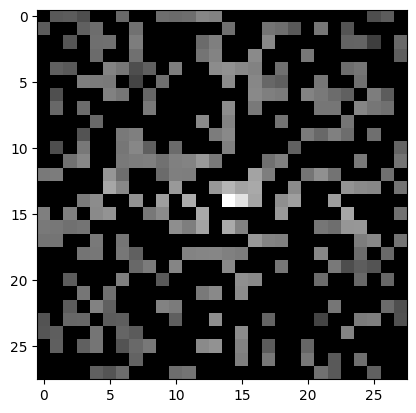

In [49]:
complex = torch.complex(item[0][0,0,:,:], item[0][0,1,:,:])
print(item[0].shape)
plt.imshow(torch.abs(torch.fft.fftshift(complex))**(1/5), cmap="gray")

In [50]:
print(item[0][0][0][0].dtype)

torch.float32


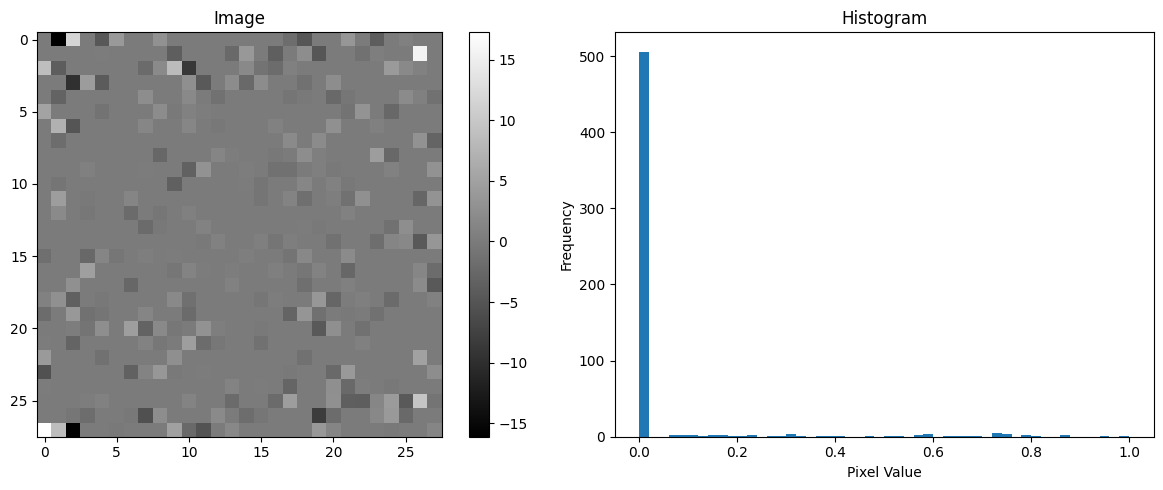

In [52]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [55]:
model = ViT(
    image_size = 28,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)

img = torch.randn(1, 2, 28, 28)

preds = model(img) # (1, 1000)

In [56]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6337486


In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [58]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:


model.to(device)
epochs = 1000
for epoch in range(581, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 581: 100%|██████████| 938/938 [00:13<00:00, 67.33batch/s, Train Loss=0.713, Train Acc=74.4]


Epoch 581
Train Loss: 0.7125, Train Accuracy: 74.39%
Test Loss: 0.4249, Test Accuracy: 84.54%



Epoch 582: 100%|██████████| 938/938 [00:13<00:00, 69.13batch/s, Train Loss=0.493, Train Acc=81.9]


Epoch 582
Train Loss: 0.4928, Train Accuracy: 81.94%
Test Loss: 0.3751, Test Accuracy: 86.57%



Epoch 583: 100%|██████████| 938/938 [00:13<00:00, 69.25batch/s, Train Loss=0.445, Train Acc=83.8]


Epoch 583
Train Loss: 0.4448, Train Accuracy: 83.81%
Test Loss: 0.3608, Test Accuracy: 87.00%



Epoch 584: 100%|██████████| 938/938 [00:13<00:00, 69.36batch/s, Train Loss=0.416, Train Acc=84.7]


Epoch 584
Train Loss: 0.4164, Train Accuracy: 84.71%
Test Loss: 0.3443, Test Accuracy: 87.53%



Epoch 585: 100%|██████████| 938/938 [00:13<00:00, 69.26batch/s, Train Loss=0.393, Train Acc=85.5]


Epoch 585
Train Loss: 0.3932, Train Accuracy: 85.54%
Test Loss: 0.3304, Test Accuracy: 87.84%



Epoch 586: 100%|██████████| 938/938 [00:13<00:00, 69.47batch/s, Train Loss=0.379, Train Acc=86]  


Epoch 586
Train Loss: 0.3786, Train Accuracy: 86.04%
Test Loss: 0.3203, Test Accuracy: 88.36%



Epoch 587: 100%|██████████| 938/938 [00:13<00:00, 69.14batch/s, Train Loss=0.364, Train Acc=86.7]


Epoch 587
Train Loss: 0.3637, Train Accuracy: 86.71%
Test Loss: 0.3227, Test Accuracy: 88.07%



Epoch 588: 100%|██████████| 938/938 [00:13<00:00, 68.85batch/s, Train Loss=0.349, Train Acc=87.1]


Epoch 588
Train Loss: 0.3493, Train Accuracy: 87.06%
Test Loss: 0.3149, Test Accuracy: 88.85%



Epoch 589: 100%|██████████| 938/938 [00:13<00:00, 68.86batch/s, Train Loss=0.338, Train Acc=87.6]


Epoch 589
Train Loss: 0.3381, Train Accuracy: 87.57%
Test Loss: 0.3119, Test Accuracy: 89.16%



Epoch 590: 100%|██████████| 938/938 [00:13<00:00, 68.98batch/s, Train Loss=0.328, Train Acc=87.9]


Epoch 590
Train Loss: 0.3283, Train Accuracy: 87.88%
Test Loss: 0.3034, Test Accuracy: 88.88%



Epoch 591: 100%|██████████| 938/938 [00:13<00:00, 69.08batch/s, Train Loss=0.321, Train Acc=88]  


Epoch 591
Train Loss: 0.3210, Train Accuracy: 88.01%
Test Loss: 0.3021, Test Accuracy: 89.31%



Epoch 592: 100%|██████████| 938/938 [00:13<00:00, 68.86batch/s, Train Loss=0.313, Train Acc=88.3]


Epoch 592
Train Loss: 0.3133, Train Accuracy: 88.32%
Test Loss: 0.3028, Test Accuracy: 89.16%



Epoch 593: 100%|██████████| 938/938 [00:13<00:00, 69.10batch/s, Train Loss=0.302, Train Acc=88.9]


Epoch 593
Train Loss: 0.3025, Train Accuracy: 88.87%
Test Loss: 0.2963, Test Accuracy: 89.47%



Epoch 594: 100%|██████████| 938/938 [00:13<00:00, 68.69batch/s, Train Loss=0.296, Train Acc=88.9]


Epoch 594
Train Loss: 0.2959, Train Accuracy: 88.88%
Test Loss: 0.2966, Test Accuracy: 89.50%



Epoch 595: 100%|██████████| 938/938 [00:13<00:00, 68.78batch/s, Train Loss=0.29, Train Acc=89.1] 


Epoch 595
Train Loss: 0.2898, Train Accuracy: 89.11%
Test Loss: 0.2936, Test Accuracy: 89.74%



Epoch 596: 100%|██████████| 938/938 [00:13<00:00, 68.58batch/s, Train Loss=0.283, Train Acc=89.5]


Epoch 596
Train Loss: 0.2835, Train Accuracy: 89.52%
Test Loss: 0.2966, Test Accuracy: 89.47%



Epoch 597: 100%|██████████| 938/938 [00:13<00:00, 68.57batch/s, Train Loss=0.274, Train Acc=89.8]


Epoch 597
Train Loss: 0.2737, Train Accuracy: 89.81%
Test Loss: 0.2955, Test Accuracy: 89.62%



Epoch 598: 100%|██████████| 938/938 [00:13<00:00, 68.88batch/s, Train Loss=0.269, Train Acc=90]  


Epoch 598
Train Loss: 0.2691, Train Accuracy: 90.00%
Test Loss: 0.2903, Test Accuracy: 89.87%



Epoch 599: 100%|██████████| 938/938 [00:13<00:00, 68.97batch/s, Train Loss=0.263, Train Acc=90.2]


Epoch 599
Train Loss: 0.2628, Train Accuracy: 90.19%
Test Loss: 0.2948, Test Accuracy: 89.84%



Epoch 600: 100%|██████████| 938/938 [00:13<00:00, 68.80batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 600
Train Loss: 0.2571, Train Accuracy: 90.24%
Test Loss: 0.2965, Test Accuracy: 89.62%



Epoch 601: 100%|██████████| 938/938 [00:13<00:00, 68.71batch/s, Train Loss=0.254, Train Acc=90.5]


Epoch 601
Train Loss: 0.2539, Train Accuracy: 90.53%
Test Loss: 0.2926, Test Accuracy: 90.21%



Epoch 602: 100%|██████████| 938/938 [00:13<00:00, 68.58batch/s, Train Loss=0.245, Train Acc=90.9]


Epoch 602
Train Loss: 0.2445, Train Accuracy: 90.92%
Test Loss: 0.2922, Test Accuracy: 90.07%



Epoch 603: 100%|██████████| 938/938 [00:13<00:00, 68.25batch/s, Train Loss=0.241, Train Acc=91]  


Epoch 603
Train Loss: 0.2408, Train Accuracy: 90.97%
Test Loss: 0.3019, Test Accuracy: 89.59%



Epoch 604: 100%|██████████| 938/938 [00:13<00:00, 68.01batch/s, Train Loss=0.234, Train Acc=91.2]


Epoch 604
Train Loss: 0.2340, Train Accuracy: 91.24%
Test Loss: 0.2980, Test Accuracy: 89.94%



Epoch 605: 100%|██████████| 938/938 [00:13<00:00, 68.09batch/s, Train Loss=0.232, Train Acc=91.4]


Epoch 605
Train Loss: 0.2323, Train Accuracy: 91.42%
Test Loss: 0.2992, Test Accuracy: 90.01%



Epoch 606: 100%|██████████| 938/938 [00:13<00:00, 68.37batch/s, Train Loss=0.226, Train Acc=91.5]


Epoch 606
Train Loss: 0.2255, Train Accuracy: 91.52%
Test Loss: 0.2984, Test Accuracy: 90.12%



Epoch 607: 100%|██████████| 938/938 [00:13<00:00, 68.28batch/s, Train Loss=0.219, Train Acc=91.7]


Epoch 607
Train Loss: 0.2195, Train Accuracy: 91.67%
Test Loss: 0.3038, Test Accuracy: 89.79%



Epoch 608: 100%|██████████| 938/938 [00:13<00:00, 68.45batch/s, Train Loss=0.218, Train Acc=91.9]


Epoch 608
Train Loss: 0.2179, Train Accuracy: 91.87%
Test Loss: 0.3070, Test Accuracy: 90.21%



Epoch 609: 100%|██████████| 938/938 [00:13<00:00, 68.58batch/s, Train Loss=0.215, Train Acc=92]  


Epoch 609
Train Loss: 0.2151, Train Accuracy: 91.98%
Test Loss: 0.3050, Test Accuracy: 90.16%



Epoch 610: 100%|██████████| 938/938 [00:13<00:00, 68.83batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 610
Train Loss: 0.2084, Train Accuracy: 92.13%
Test Loss: 0.3138, Test Accuracy: 90.13%



Epoch 611: 100%|██████████| 938/938 [00:13<00:00, 68.53batch/s, Train Loss=0.206, Train Acc=92.2]


Epoch 611
Train Loss: 0.2055, Train Accuracy: 92.23%
Test Loss: 0.3219, Test Accuracy: 89.83%



Epoch 612: 100%|██████████| 938/938 [00:13<00:00, 68.83batch/s, Train Loss=0.204, Train Acc=92.4]


Epoch 612
Train Loss: 0.2039, Train Accuracy: 92.37%
Test Loss: 0.3255, Test Accuracy: 89.86%



Epoch 613: 100%|██████████| 938/938 [00:13<00:00, 68.55batch/s, Train Loss=0.194, Train Acc=92.7]


Epoch 613
Train Loss: 0.1944, Train Accuracy: 92.69%
Test Loss: 0.3249, Test Accuracy: 89.97%



Epoch 614: 100%|██████████| 938/938 [00:13<00:00, 68.74batch/s, Train Loss=0.196, Train Acc=92.6]


Epoch 614
Train Loss: 0.1955, Train Accuracy: 92.63%
Test Loss: 0.3225, Test Accuracy: 89.98%



Epoch 615: 100%|██████████| 938/938 [00:13<00:00, 68.26batch/s, Train Loss=0.191, Train Acc=93]  


Epoch 615
Train Loss: 0.1905, Train Accuracy: 92.98%
Test Loss: 0.3234, Test Accuracy: 90.07%



Epoch 616: 100%|██████████| 938/938 [00:13<00:00, 68.47batch/s, Train Loss=0.188, Train Acc=93]  


Epoch 616
Train Loss: 0.1877, Train Accuracy: 92.98%
Test Loss: 0.3200, Test Accuracy: 90.13%



Epoch 617: 100%|██████████| 938/938 [00:13<00:00, 67.82batch/s, Train Loss=0.186, Train Acc=93.1]


Epoch 617
Train Loss: 0.1860, Train Accuracy: 93.09%
Test Loss: 0.3204, Test Accuracy: 90.06%



Epoch 618: 100%|██████████| 938/938 [00:13<00:00, 68.41batch/s, Train Loss=0.183, Train Acc=93.2]


Epoch 618
Train Loss: 0.1827, Train Accuracy: 93.16%
Test Loss: 0.3327, Test Accuracy: 89.88%



Epoch 619: 100%|██████████| 938/938 [00:13<00:00, 67.89batch/s, Train Loss=0.18, Train Acc=93.2] 


Epoch 619
Train Loss: 0.1799, Train Accuracy: 93.25%
Test Loss: 0.3272, Test Accuracy: 90.10%



Epoch 620: 100%|██████████| 938/938 [00:14<00:00, 66.93batch/s, Train Loss=0.178, Train Acc=93.3]


Epoch 620
Train Loss: 0.1780, Train Accuracy: 93.32%
Test Loss: 0.3345, Test Accuracy: 90.00%



Epoch 621: 100%|██████████| 938/938 [00:13<00:00, 68.01batch/s, Train Loss=0.173, Train Acc=93.6]


Epoch 621
Train Loss: 0.1732, Train Accuracy: 93.57%
Test Loss: 0.3335, Test Accuracy: 90.40%



Epoch 622: 100%|██████████| 938/938 [00:13<00:00, 68.54batch/s, Train Loss=0.173, Train Acc=93.7]


Epoch 622
Train Loss: 0.1725, Train Accuracy: 93.66%
Test Loss: 0.3444, Test Accuracy: 90.31%



Epoch 623: 100%|██████████| 938/938 [00:13<00:00, 67.59batch/s, Train Loss=0.166, Train Acc=93.8]


Epoch 623
Train Loss: 0.1661, Train Accuracy: 93.76%
Test Loss: 0.3479, Test Accuracy: 89.96%



Epoch 624: 100%|██████████| 938/938 [00:13<00:00, 68.16batch/s, Train Loss=0.166, Train Acc=93.8]


Epoch 624
Train Loss: 0.1660, Train Accuracy: 93.81%
Test Loss: 0.3493, Test Accuracy: 89.92%



Epoch 625:  93%|█████████▎| 872/938 [00:12<00:00, 67.71batch/s, Train Loss=0.164, Train Acc=93.8]


KeyboardInterrupt: 

In [64]:
def save_model(model, optimizer, epoch, loss, accuracy, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, filename)


In [70]:
save_model(model, optimizer, epochs, test_loss, test_accuracy, 'final_model.pth')

In [20]:
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    return model, optimizer, epoch, loss, accuracy

# Usage
model, optimizer, epoch, loss, accuracy = load_model(model, optimizer, 'final_model.pth')